# Comment-Level KPI and Engagement Analysis

This notebook provides a comprehensive workflow for analyzing YouTube comment data to extract key performance indicators (KPIs) and engagement metrics. The main objectives are to clean and preprocess comment data, perform sentiment and engagement analysis, and visualize results to gain actionable insights. The workflow includes:

- **Data Loading and Cleaning:** Importing raw comment data and handling missing or inconsistent values.
- **Preprocessing:** Text normalization, tokenization, and preparation for analysis.
- **Sentiment Analysis:** Applying NLP techniques to classify comment sentiment (positive, negative, neutral).
- **KPI Calculation:** Computing metrics such as comment counts, engagement rates, and sentiment distributions.
- **Visualization:** Creating plots and tables to summarize findings and highlight trends.
- **Exporting Results:** Saving processed data and visualizations for reporting or further analysis.

This notebook is designed for reproducibility and clarity, with detailed markdown explanations and code comments throughout each step.

## Importing Required Libraries and Setting Display Options
This cell imports all necessary libraries for data manipulation, visualization, and progress tracking. It also configures pandas display options for better readability and disables scientific notation and warnings.

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Enable tqdm for pandas apply
tqdm.pandas()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show full text without truncation
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 500) 

# Disable scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

## Load Main Dataset
This cell loads the main dataset containing YouTube comments and associated metadata, then displays its shape to confirm successful loading.

In [2]:
df = pd.read_csv('dataset/final_after_spam_eng_relevance_sentiment_aspect_final_2M.csv')
df.shape

(2028655, 23)

## Load Video Metadata
This cell loads the cleaned and translated video metadata and displays its shape to confirm successful loading.

In [ ]:
video = pd.read_csv("dataset/videos_cleaned_translated.csv")
video.shape

(91113, 21)

## Prepare Video Metadata Subset
This cell selects relevant columns from the video metadata, renames them with a prefix for clarity, and prepares the subset for merging with the main dataset.

In [ ]:
video_subset = video[['videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags',
                      'viewCount', 'likeCount', 'commentCount', 
                      'translated','extracted_topicCategories_str']]

# Add prefix to all column names
video_subset = video_subset.add_prefix("v_")

##### Merge Videos to Comments 

## Merge Video Metadata with Main Dataset
This cell fills missing view counts, prints the shape of the main DataFrame before and after merging, and merges the video metadata into the main dataset using the videoId as the key.

In [8]:
# Replace missing view counts with 0
video_subset['v_viewCount'] = video_subset['v_viewCount'].fillna(0)

# Print shape of the main DataFrame before merging
print(df.shape)

# Merge video details into df using videoId as the key
df = df.merge(video_subset, left_on='videoId', right_on='v_videoId', how='inner')

# Print shape of the DataFrame after merging
print(df.shape)


(2028655, 23)
(2014093, 37)


## Drop Unnecessary Columns
This cell removes the 'Unnamed: 0' column from the DataFrame, which is often an artifact from CSV exports.

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Analyze Comment Frequency
This cell calculates how frequently each comment appears in the dataset and provides descriptive statistics for comment repetition.

In [11]:
# Find out how frequently a comment appears in the dataset 
comments_counts = df['cleanedText'].value_counts()
comments_counts.describe().T

count   1598543.000000
mean          1.259955
std          19.492546
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       15740.000000
Name: count, dtype: float64

## Display Most Frequent Comments
This cell displays the top 10 most frequent comments in the dataset.

In [12]:
comments_counts.head(10)

cleanedText
beautiful               15740
pretty                  11501
love                     9638
cute                     5838
night look beautiful     3038
look beautiful           2833
gorgeous                 2595
nice                     2492
beautiful way            2104
like                     2055
Name: count, dtype: int64

## Calculate Comment Frequency and Repetitiveness
This cell maps the frequency of each comment to the DataFrame, calculates the repetitiveness as a proportion, and provides descriptive statistics for these new features.

In [13]:
df['comment_frequency'] = df['cleanedText'].map(comments_counts)
df['comment_repetitiveness'] = df['comment_frequency'] / len(df)
df[['comment_frequency', 'comment_repetitiveness']].describe().T

,count,mean,std,min,25%,50%,75%,max
comment_frequency,2014093.000000,302.825459,1794.138943,1.000000,1.000000,1.000000,1.000000,15740.000000
comment_repetitiveness,2014093.000000,0.000150,0.000891,0.000000,0.000000,0.000000,0.000000,0.007815


## Analyze Word Length in Comments
This cell calculates the word length (token count) for each comment and provides descriptive statistics. It also sets up for determining the appropriate window size for further analysis.

In [14]:
# Word length (token count) 
df['word_length'] = df['cleanedText'].str.split().str.len()
df['word_length'].describe().T

# Based on the mean and word length, we determine the right window size. 

count   2014093.000000
mean          7.289324
std          10.084477
min           1.000000
25%           3.000000
50%           5.000000
75%           8.000000
max        1120.000000
Name: word_length, dtype: float64

## Define MATTR Calculation Function
This cell defines a function to calculate the Moving-Average Type-Token Ratio (MATTR) for a given comment, which is a measure of lexical diversity using a sliding window approach.

In [15]:
# Function to calculate MATTR for one comment
def calc_mattr(tokens, window_size=10):
    if len(tokens) == 0:
        return 0
    if len(tokens) <= window_size:
        # Just return normal TTR if comment is shorter than the window
        return len(set(tokens)) / len(tokens)
    
    # Sliding window TTR
    ttr_values = []
    for i in range(len(tokens) - window_size + 1):
        window = tokens[i:i+window_size]
        ttr_values.append(len(set(window)) / window_size)
    
    return sum(ttr_values) / len(ttr_values)

## Apply MATTR and TTR to Comments
This cell applies the MATTR function to each comment to measure lexical diversity, and also calculates the Type-Token Ratio (TTR) for each comment.

In [16]:
# Apply MATTR at comment level
df["MATTR"] = df["cleanedText"].str.split().progress_apply(lambda x: calc_mattr(x, window_size=10))

# Calculate TTR (Type-Token Ratio)
df["TTR"] = df["cleanedText"].str.split().progress_apply(
    lambda x: len(set(x)) / len(x) if len(x) > 0 else 0
)


100%|██████████| 2014093/2014093 [00:03<00:00, 529683.37it/s]


## Visualize and Correlate Lexical Diversity
This cell creates scatter plots to compare TTR and MATTR against comment length, and calculates the correlation between comment length and both metrics.

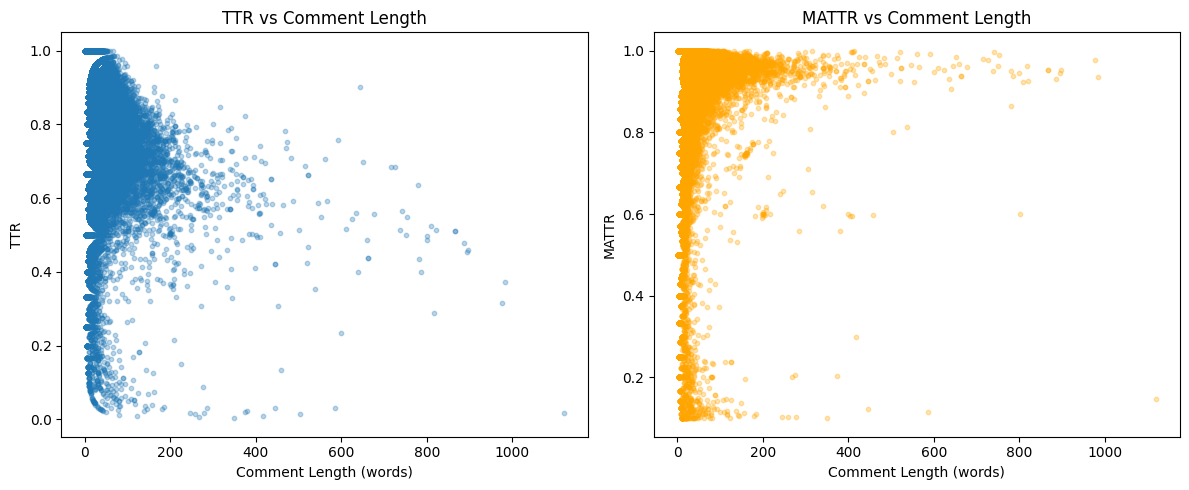

Correlation between comment length and TTR: -0.455
Correlation between comment length and MATTR: -0.193


In [ ]:
# Compare TTR to MATTR
# === Scatter plots ===
plt.figure(figsize=(12,5))

# TTR scatter
plt.subplot(1,2,1)
plt.scatter(df["word_length"], df["TTR"], alpha=0.3, s=10)
plt.xlabel("Comment Length (words)")
plt.ylabel("TTR")
plt.title("TTR vs Comment Length")

# MATTR scatter
plt.subplot(1,2,2)
plt.scatter(df["word_length"], df["MATTR"], alpha=0.3, s=10, color="orange")
plt.xlabel("Comment Length (words)")
plt.ylabel("MATTR")
plt.title("MATTR vs Comment Length")

plt.tight_layout()
plt.show()

# === Correlation check ===
corr_ttr = df["word_length"].corr(df["TTR"])
corr_mattr = df["word_length"].corr(df["MATTR"])

print(f"Correlation between comment length and TTR: {corr_ttr:.3f}")
print(f"Correlation between comment length and MATTR: {corr_mattr:.3f}")


## Summarize Engagement Metrics
This cell provides descriptive statistics for view and like counts, which are used to assess comment engagement.

In [18]:
df[['v_viewCount', 'likeCount']].describe().T

,count,mean,std,min,25%,50%,75%,max
v_viewCount,2014093.000000,18132337.984750,26486118.703819,0.000000,1841570.000000,8315555.000000,23657752.000000,405748145.000000
likeCount,2014093.000000,19.011844,793.312637,0.000000,0.000000,0.000000,0.000000,456142.000000


## Calculate Engagement Score
This cell calculates an engagement score for each comment based on the ratio of likes to views, and provides descriptive statistics for this new metric.

In [19]:
df['engagementScore'] = df.progress_apply(
    lambda row: row['likeCount'] / row['v_viewCount'] if row['v_viewCount'] > 0 else 0,
    axis=1
)

df['engagementScore'].describe().T

100%|██████████| 2014093/2014093 [00:25<00:00, 77474.80it/s] 


count   2014093.000000
mean          0.000030
std           0.000998
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.571429
Name: engagementScore, dtype: float64

## Assign Sentiment Labels
This cell calculates the sentiment magnitude for each comment and assigns a sentiment label (positive, negative, or neutral) based on the highest score.

In [20]:
df['sentiment_magnitude'] = df[['positive', 'negative']].max(axis=1)

# Get column with max score
df['sentiment_label'] = df[['positive', 'negative', 'neutral']].idxmax(axis=1)
df['sentiment_label'].value_counts()

sentiment_label
positive    1059534
negative     901497
neutral       53062
Name: count, dtype: int64

## Calculate Constructiveness Metrics
This cell calculates the number of aspects per comment, counts the number of polarized aspects (positive or negative), and computes the ratio of polarized aspects to total aspects for each comment.

In [21]:
import ast

# Count number of aspects (convert string to list if needed)
df['aspect_count'] = df['aspect'].progress_apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x)
)

# Count Positive + Negative sentiments
df['polarized_aspect_count'] = df['sentiment'].progress_apply(
    lambda s: s.count('Positive') + s.count('Negative')
)

# Compute ratio: (Positive + Negative) / total aspects
df['polarized_aspect_ratio'] = df.progress_apply(
    lambda row: row['polarized_aspect_count'] / row['aspect_count']
    if row['aspect_count'] > 0 else 0,
    axis=1
)


100%|██████████| 2014093/2014093 [00:22<00:00, 89291.16it/s] 


## Scale Relevance Score
This cell scales the relevance score to ensure all values are between 0 and 1, which is important for combining with other metrics.

In [23]:
df['relevance_score_scaled'] = np.clip(df['relevance_score'], 0, 1)

## Log-Transform Word Length
This cell applies a log transformation to the word length feature to reduce skewness and improve scaling for further analysis.

In [24]:
df['word_length'] = np.log1p(df['word_length'])

In [25]:
df['word_length'].describe().T

count   2014093.000000
mean          1.832578
std           0.686040
min           0.693147
25%           1.386294
50%           1.791759
75%           2.197225
max           7.021976
Name: word_length, dtype: float64

## Scale Key Features
This cell uses MinMaxScaler to scale selected features to the [0, 1] range, preparing them for use in the KPI calculation.

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Columns to scale
cols_to_scale = ['polarized_aspect_count', 'comment_repetitiveness', 'engagementScore', 'word_length']

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform
scaled_values = scaler.fit_transform(df[cols_to_scale])

# Add scaled columns with a suffix '_scaled'
for i, col in enumerate(cols_to_scale):
    df[col + '_scaled'] = scaled_values[:, i]

# Check result
df[[col + '_scaled' for col in cols_to_scale]].head()

,polarized_aspect_count_scaled,comment_repetitiveness_scaled,engagementScore_scaled,word_length_scaled
0,0.083333,0.000000,0.000000,0.173589
1,0.083333,0.000000,0.000000,0.283111
2,0.083333,0.002097,0.000135,0.064066
3,0.083333,0.000000,0.000630,0.144780
4,0.083333,0.000000,0.000000,0.109522


## Describe Numeric Columns
This cell provides a transposed summary of all numeric columns in the DataFrame, showing key statistics for each feature.

In [27]:
# Describe numeric columns
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
commentId,2014093.000000,2392990.044585,1349409.077649,0.000000,1229192.000000,2395276.000000,3561061.000000,4725015.000000
channelId,2014093.000000,26594.173586,15000.551109,1.000000,14429.000000,25475.000000,40271.000000,53677.000000
videoId,2014093.000000,46747.864226,26053.460335,2.000000,25694.000000,47096.000000,69191.000000,92854.000000
authorId,2014093.000000,1785780.998183,1037899.731257,1.000000,883767.000000,1784786.000000,2657992.000000,3659440.000000
parentCommentId,195718.000000,2619018.627454,1214276.956844,516151.000000,1567555.000000,2620141.000000,3671640.500000,4725006.000000
likeCount,2014093.000000,19.011844,793.312637,0.000000,0.000000,0.000000,0.000000,456142.000000
duplicatedFlag,2014093.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
regex_spam,2014093.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
predicted_spam,2014093.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
isSpam,2014093.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Calculate KPI (Key Performance Indicator)
This cell defines the weights for each scaled feature and computes a composite KPI score for each comment using a weighted sum.

In [28]:
# Define weights
weights = {
    'relevance_score_scaled': 0.25,
    'engagementScore_scaled': 0.1,
    'sentiment_magnitude': 0.15,
    'comment_repetitiveness_scaled': 0.1,
    'MATTR': 0.05,
    'polarized_aspect_count_scaled': 0.0,
    'polarized_aspect_ratio': 0.20,
    'word_length_scaled':0.15
}

# Compute weighted KPI
df['KPI'] = (
    df['relevance_score_scaled'] * weights['relevance_score_scaled'] +
    df['engagementScore_scaled'] * weights['engagementScore_scaled'] +
    df['sentiment_magnitude'] * weights['sentiment_magnitude'] +
    df['comment_repetitiveness_scaled'] * weights['comment_repetitiveness_scaled'] +
    df['MATTR'] * weights['MATTR'] +
    df['polarized_aspect_count_scaled'] * weights['polarized_aspect_count_scaled'] +
    df['polarized_aspect_ratio'] * weights['polarized_aspect_ratio'] + 
    df['word_length_scaled'] * weights['word_length_scaled']
)


## Summarize KPI Distribution
This cell provides descriptive statistics for the calculated KPI values across all comments.

In [29]:
df['KPI'].describe().T

count   2014093.000000
mean          0.312134
std           0.121477
min           0.062030
25%           0.212738
50%           0.270543
75%           0.427181
max           0.685384
Name: KPI, dtype: float64

## Visualize KPI Distribution
This cell plots a histogram of the KPI values to visualize their distribution across all comments.

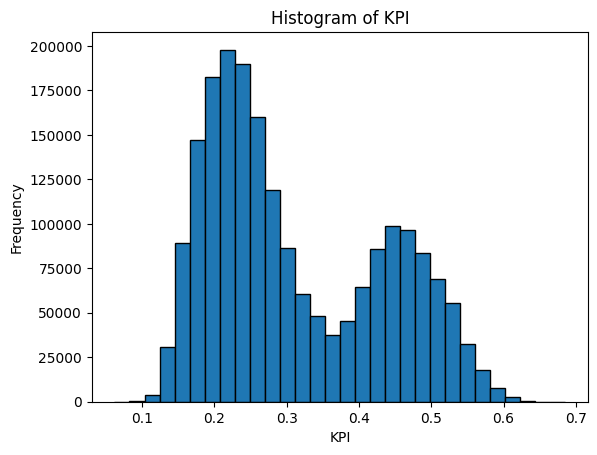

In [30]:
# distribution of KPI 
df['KPI'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of KPI')
plt.xlabel('KPI')
plt.ylabel('Frequency')
plt.show()

## Export High-KPI Comments
This cell exports comments with a KPI greater than 0.60 to a CSV file for further analysis.

In [57]:
df.loc[df['KPI']>0.60][['textOriginal', "v_title"]].to_csv("dataset/KPI_high.csv", index = False)

## Count High-KPI Comments
This cell counts the number of comments with a KPI greater than 0.65.

In [32]:
df.loc[df['KPI']>0.65].shape

(25, 53)

## Sort Comments by KPI
This cell sorts the DataFrame in descending order of KPI, so the most impactful comments appear first.

In [37]:
df.sort_values(by = 'KPI', ascending = False, inplace = True)

## Bin and Count KPI Values
This cell bins the KPI values into intervals of 0.1 and counts the number of comments in each bin, providing a summary of KPI distribution.

In [51]:
# Define bins from 0 to 1 with step size 0.1
bins = np.arange(0, 1.1, 0.1)   # [0.0, 0.1, 0.2, ..., 1.0]

# Bin KPI values
kpi_bins = pd.cut(df['KPI'], bins=bins, include_lowest=True)

# Count values per bin, sorted by range
kpi_bins.value_counts(sort=False).to_frame()

,count
KPI,
"(-0.001, 0.1]",314
"(0.1, 0.2]",385060
"(0.2, 0.3]",778798
"(0.3, 0.4]",249440
"(0.4, 0.5]",420679
"(0.5, 0.6]",175997
"(0.6, 0.7]",3805
"(0.7, 0.8]",0
"(0.8, 0.9]",0


##### Generating output 

## Prepare Final Output DataFrame
This cell drops unnecessary columns and prepares the final DataFrame for export, then displays its structure using the `info()` method.

In [ ]:
df_output = df.drop(columns=['v_videoId',
       'v_publishedAt', 'v_channelId', 'v_title', 'v_description', 'v_tags',
       'v_viewCount', 'v_likeCount', 'v_commentCount', 'v_translated',
       'v_extracted_topicCategories_str', 'comment_frequency',
       'comment_repetitiveness', 'word_length', 'MATTR', 'TTR',
       'engagementScore', 'sentiment_magnitude', 'sentiment_label',
       'aspect_count', 'polarized_aspect_count', 'polarized_aspect_ratio',
       'relevance_score_scaled', 'polarized_aspect_count_scaled',
       'comment_repetitiveness_scaled', 'engagementScore_scaled',
       'word_length_scaled'])

df_output.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2014093 entries, 1504448 to 306536
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   commentId             int64  
 1   channelId             int64  
 2   videoId               int64  
 3   authorId              int64  
 4   textOriginal          object 
 5   parentCommentId       float64
 6   likeCount             int64  
 7   publishedAt           object 
 8   updatedAt             object 
 9   duplicatedFlag        int64  
 10  cleanedText           object 
 11  cleanedTextSentiment  object 
 12  regex_spam            int64  
 13  predicted_spam        float64
 14  isSpam                int64  
 15  is_english            int64  
 16  relevance_score       float64
 17  negative              float64
 18  neutral               float64
 19  positive              float64
 20  aspect                object 
 21  sentiment             object 
 22  KPI                   float64
dtypes: floa

## Export Final DataFrame to CSV
This cell exports the final DataFrame with KPI and selected features to a CSV file for downstream analysis or reporting.

In [39]:
df_output.to_csv("dataset/final_dataset_with_kpi.csv", index=False)